In [10]:
#pip install keras-tuner
#pip install --upgrade keras

In [11]:
#pip install tensorflow==2.13.0

In [12]:
# Bibliotecas de manipulação de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score

# Keras (via TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Otimização de hiperparâmetros
from kerastuner.tuners import RandomSearch

# TensorFlow
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [13]:
base = pd.read_csv('data_balanceado_sem_pre_diabetes.csv')
base.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'Smoker', 'PhysActivity',
       'Fruits', 'Veggies', 'GenHlth', 'Sex', 'Age'],
      dtype='object')

In [14]:
X = base.drop(['Diabetes_012'], axis=1)
y = base['Diabetes_012'].astype(int).values
print(y.shape)
print(y)
base['Diabetes_012'].value_counts()

(42448,)
[1 0 0 ... 1 0 0]


Diabetes_012
1.0    21224
0.0    21224
Name: count, dtype: int64

In [15]:
# Transformando a classe em formato "dummy"
y = to_categorical(y, num_classes=2)
print(y.shape)
print(y)

(42448, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [16]:
# Parâmetros do random subsampling
n_rep = 20

# Vetor com as métricas  de cada subsampling
acuracias = []
precisions = []
recalls = []
f1_scores = []
matrizes_confusao = []

# Curva ROC
fpr_list = []
tpr_list = []
auc_list = []

# Histórico das acurácias
historico_accuracy = []
historico_val_accuracy = []

In [17]:
for i in range(n_rep):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

    # Normalizar os dados de entrada
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    modelo = Sequential()
    modelo.add(Input(shape=(X.shape[1],)))  # camada de entrada

    # Primeira camada oculta + Dropout
    modelo.add(Dense(144, activation='relu'))
    modelo.add(Dropout(0.2))

    # Segunda camada oculta + Dropout
    modelo.add(Dense(104, activation='relu'))
    modelo.add(Dropout(0.2))

    # Camada de saída
    modelo.add(Dense(2, activation='softmax'))

    # Compilação
    opt = Adam(learning_rate=1e-5)
    modelo.compile(optimizer=opt,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=40, min_lr=1e-8)

    # Treinamento
    historico = modelo.fit(X_train, y_train,
                           epochs=25,
                           validation_data=(X_test, y_test),
                           callbacks=[early_stop, rlr],
                           verbose=1)

    # Predição
    # Obtenção das probabilidades sobre o conjunto teste
    y_pred_probs = modelo.predict(X_test)

    # Converter de one-hot para rótulos (índices das classes)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Guardando métricas
    # O peso (weighted) é dado de acordo com ocorrência da classe
    # Sem divisão por zero
    acuracias.append(accuracy_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(y_true, y_pred, average='weighted', zero_division=0))
    f1_scores.append(f1_score(y_true, y_pred, average='weighted', zero_division=0))
    matrizes_confusao.append(confusion_matrix(y_true, y_pred))

    # Curva ROC
    y_prob = y_pred_probs[:, 1]

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    # Histórico da acurácia
    historico_accuracy.append(historico.history['accuracy'])
    historico_val_accuracy.append(historico.history['val_accuracy'])

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25
929/929 [==============================] - 55s 59ms/step - loss: 0.6979 - accuracy: 0.5444 - val_loss: 0.6294 - val_accuracy: 0.6491 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 55s 59ms/step - loss: 0.6092 - accuracy: 0.6654 - val_loss: 0.5789 - val_accuracy: 0.7154 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 55s 59ms/step - loss: 0.5735 - accuracy: 0.7061 - val_loss: 0.5582 - val_accuracy: 0.7218 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 54s 58ms/step - loss: 0.5595 - accuracy: 0.7155 - val_loss: 0.5504 - val_accuracy: 0.7244 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 50s 53ms/step - loss: 0.5540 - accuracy: 0.7194 - val_loss: 0.5474 - val_accuracy: 0.7256 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 48s 52ms/step - loss: 0.5513 - accuracy: 0.7213 - val_loss: 0.5459 - val_accuracy: 0.7264 - lr: 1.0000e-05
Epoch 7/25
929/929 [==============

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 44s 47ms/step - loss: 0.6615 - accuracy: 0.5902 - val_loss: 0.5996 - val_accuracy: 0.6915 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 48s 51ms/step - loss: 0.5879 - accuracy: 0.6956 - val_loss: 0.5587 - val_accuracy: 0.7194 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 46s 50ms/step - loss: 0.5647 - accuracy: 0.7118 - val_loss: 0.5466 - val_accuracy: 0.7240 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 44s 48ms/step - loss: 0.5553 - accuracy: 0.7182 - val_loss: 0.5426 - val_accuracy: 0.7268 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 48s 52ms/step - loss: 0.5527 - accuracy: 0.7174 - val_loss: 0.5409 - val_accuracy: 0.7275 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 46s 50ms/step - loss: 0.5516 - accuracy: 0.7219 - val_loss: 0.5400 - val_accuracy: 0.7281 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 49s 53ms/step - loss: 0.6804 - accuracy: 0.5708 - val_loss: 0.6285 - val_accuracy: 0.6782 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 47s 50ms/step - loss: 0.6113 - accuracy: 0.6802 - val_loss: 0.5794 - val_accuracy: 0.7160 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 50s 54ms/step - loss: 0.5772 - accuracy: 0.7088 - val_loss: 0.5564 - val_accuracy: 0.7237 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 47s 50ms/step - loss: 0.5618 - accuracy: 0.7150 - val_loss: 0.5466 - val_accuracy: 0.7252 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 52s 56ms/step - loss: 0.5562 - accuracy: 0.7201 - val_loss: 0.5424 - val_accuracy: 0.7267 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 47s 51ms/step - loss: 0.5530 - accuracy: 0.7194 - val_loss: 0.5405 - val_accuracy: 0.7267 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 82s 88ms/step - loss: 0.6790 - accuracy: 0.5691 - val_loss: 0.6260 - val_accuracy: 0.6824 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 97s 104ms/step - loss: 0.6055 - accuracy: 0.6817 - val_loss: 0.5797 - val_accuracy: 0.7104 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 87s 94ms/step - loss: 0.5736 - accuracy: 0.7063 - val_loss: 0.5598 - val_accuracy: 0.7162 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 99s 107ms/step - loss: 0.5585 - accuracy: 0.7167 - val_loss: 0.5523 - val_accuracy: 0.7190 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 92s 99ms/step - loss: 0.5529 - accuracy: 0.7171 - val_loss: 0.5494 - val_accuracy: 0.7200 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 92s 99ms/step - loss: 0.5509 - accuracy: 0.7218 - val_loss: 0.5483 - val_accuracy: 0.7213 - lr: 1.0000e-05
Epoch 7/25
929/929 [=======================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 89s 96ms/step - loss: 0.6547 - accuracy: 0.6197 - val_loss: 0.6094 - val_accuracy: 0.7110 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 92s 99ms/step - loss: 0.5967 - accuracy: 0.6982 - val_loss: 0.5713 - val_accuracy: 0.7212 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 83s 90ms/step - loss: 0.5680 - accuracy: 0.7138 - val_loss: 0.5550 - val_accuracy: 0.7234 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 89s 96ms/step - loss: 0.5558 - accuracy: 0.7199 - val_loss: 0.5488 - val_accuracy: 0.7256 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 88s 95ms/step - loss: 0.5520 - accuracy: 0.7192 - val_loss: 0.5463 - val_accuracy: 0.7250 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 103s 111ms/step - loss: 0.5504 - accuracy: 0.7216 - val_loss: 0.5450 - val_accuracy: 0.7260 - lr: 1.0000e-05
Epoch 7/25
929/929 [=======================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 78s 83ms/step - loss: 0.6691 - accuracy: 0.5839 - val_loss: 0.6119 - val_accuracy: 0.6909 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 77s 83ms/step - loss: 0.5931 - accuracy: 0.6944 - val_loss: 0.5665 - val_accuracy: 0.7200 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 78s 84ms/step - loss: 0.5634 - accuracy: 0.7132 - val_loss: 0.5506 - val_accuracy: 0.7253 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 78s 84ms/step - loss: 0.5539 - accuracy: 0.7183 - val_loss: 0.5453 - val_accuracy: 0.7277 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 76s 82ms/step - loss: 0.5506 - accuracy: 0.7210 - val_loss: 0.5433 - val_accuracy: 0.7277 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 78s 84ms/step - loss: 0.5497 - accuracy: 0.7204 - val_loss: 0.5424 - val_accuracy: 0.7285 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 94s 101ms/step - loss: 0.6511 - accuracy: 0.6218 - val_loss: 0.6033 - val_accuracy: 0.7117 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 98s 105ms/step - loss: 0.5962 - accuracy: 0.6945 - val_loss: 0.5639 - val_accuracy: 0.7240 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 101s 109ms/step - loss: 0.5717 - accuracy: 0.7105 - val_loss: 0.5466 - val_accuracy: 0.7303 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 100s 108ms/step - loss: 0.5614 - accuracy: 0.7131 - val_loss: 0.5391 - val_accuracy: 0.7332 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 100s 108ms/step - loss: 0.5576 - accuracy: 0.7150 - val_loss: 0.5355 - val_accuracy: 0.7348 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 100s 108ms/step - loss: 0.5544 - accuracy: 0.7173 - val_loss: 0.5337 - val_accuracy: 0.7355 - lr: 1.0000e-05
Epoch 7/25
929/929 [===============

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 51s 55ms/step - loss: 0.6386 - accuracy: 0.6400 - val_loss: 0.5892 - val_accuracy: 0.7077 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 40s 43ms/step - loss: 0.5825 - accuracy: 0.7019 - val_loss: 0.5606 - val_accuracy: 0.7205 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 42s 45ms/step - loss: 0.5633 - accuracy: 0.7169 - val_loss: 0.5512 - val_accuracy: 0.7230 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 42s 45ms/step - loss: 0.5559 - accuracy: 0.7205 - val_loss: 0.5478 - val_accuracy: 0.7238 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 42s 45ms/step - loss: 0.5512 - accuracy: 0.7204 - val_loss: 0.5463 - val_accuracy: 0.7234 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 44s 48ms/step - loss: 0.5518 - accuracy: 0.7210 - val_loss: 0.5452 - val_accuracy: 0.7242 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 38s 41ms/step - loss: 0.6305 - accuracy: 0.6516 - val_loss: 0.5801 - val_accuracy: 0.7175 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 43s 46ms/step - loss: 0.5849 - accuracy: 0.6960 - val_loss: 0.5520 - val_accuracy: 0.7259 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 43s 46ms/step - loss: 0.5693 - accuracy: 0.7099 - val_loss: 0.5414 - val_accuracy: 0.7289 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 42s 46ms/step - loss: 0.5598 - accuracy: 0.7154 - val_loss: 0.5368 - val_accuracy: 0.7306 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 48s 52ms/step - loss: 0.5559 - accuracy: 0.7193 - val_loss: 0.5342 - val_accuracy: 0.7322 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 45s 49ms/step - loss: 0.5554 - accuracy: 0.7142 - val_loss: 0.5331 - val_accuracy: 0.7337 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 41s 44ms/step - loss: 0.6691 - accuracy: 0.5869 - val_loss: 0.6171 - val_accuracy: 0.7020 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 41s 44ms/step - loss: 0.6021 - accuracy: 0.6917 - val_loss: 0.5747 - val_accuracy: 0.7180 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 47s 51ms/step - loss: 0.5727 - accuracy: 0.7107 - val_loss: 0.5570 - val_accuracy: 0.7224 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 42s 46ms/step - loss: 0.5601 - accuracy: 0.7147 - val_loss: 0.5498 - val_accuracy: 0.7243 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 46s 49ms/step - loss: 0.5543 - accuracy: 0.7182 - val_loss: 0.5466 - val_accuracy: 0.7255 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 48s 51ms/step - loss: 0.5501 - accuracy: 0.7217 - val_loss: 0.5451 - val_accuracy: 0.7263 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 41s 44ms/step - loss: 0.6572 - accuracy: 0.6111 - val_loss: 0.6088 - val_accuracy: 0.6964 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 47s 50ms/step - loss: 0.5996 - accuracy: 0.6878 - val_loss: 0.5690 - val_accuracy: 0.7198 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 46s 50ms/step - loss: 0.5741 - accuracy: 0.7059 - val_loss: 0.5511 - val_accuracy: 0.7258 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 40s 43ms/step - loss: 0.5612 - accuracy: 0.7125 - val_loss: 0.5435 - val_accuracy: 0.7268 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 38s 41ms/step - loss: 0.5563 - accuracy: 0.7175 - val_loss: 0.5398 - val_accuracy: 0.7286 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 37s 39ms/step - loss: 0.5553 - accuracy: 0.7165 - val_loss: 0.5378 - val_accuracy: 0.7300 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 42s 46ms/step - loss: 0.6645 - accuracy: 0.5936 - val_loss: 0.6144 - val_accuracy: 0.6912 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 37s 40ms/step - loss: 0.5996 - accuracy: 0.6903 - val_loss: 0.5723 - val_accuracy: 0.7143 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 36s 39ms/step - loss: 0.5697 - accuracy: 0.7099 - val_loss: 0.5549 - val_accuracy: 0.7186 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 36s 39ms/step - loss: 0.5569 - accuracy: 0.7171 - val_loss: 0.5483 - val_accuracy: 0.7211 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 36s 39ms/step - loss: 0.5532 - accuracy: 0.7205 - val_loss: 0.5455 - val_accuracy: 0.7227 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 36s 38ms/step - loss: 0.5499 - accuracy: 0.7223 - val_loss: 0.5440 - val_accuracy: 0.7236 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 38s 41ms/step - loss: 0.6759 - accuracy: 0.5825 - val_loss: 0.6143 - val_accuracy: 0.6883 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 37s 39ms/step - loss: 0.5988 - accuracy: 0.6868 - val_loss: 0.5733 - val_accuracy: 0.7093 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 40s 43ms/step - loss: 0.5695 - accuracy: 0.7104 - val_loss: 0.5596 - val_accuracy: 0.7135 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 37s 39ms/step - loss: 0.5594 - accuracy: 0.7152 - val_loss: 0.5543 - val_accuracy: 0.7173 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 37s 40ms/step - loss: 0.5543 - accuracy: 0.7187 - val_loss: 0.5522 - val_accuracy: 0.7194 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 36s 39ms/step - loss: 0.5516 - accuracy: 0.7204 - val_loss: 0.5507 - val_accuracy: 0.7212 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 38s 41ms/step - loss: 0.6589 - accuracy: 0.6178 - val_loss: 0.6052 - val_accuracy: 0.7040 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 38s 40ms/step - loss: 0.5948 - accuracy: 0.6972 - val_loss: 0.5665 - val_accuracy: 0.7184 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 40s 43ms/step - loss: 0.5699 - accuracy: 0.7098 - val_loss: 0.5502 - val_accuracy: 0.7226 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 39s 41ms/step - loss: 0.5605 - accuracy: 0.7132 - val_loss: 0.5434 - val_accuracy: 0.7273 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 40s 43ms/step - loss: 0.5553 - accuracy: 0.7179 - val_loss: 0.5400 - val_accuracy: 0.7278 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 38s 41ms/step - loss: 0.5529 - accuracy: 0.7215 - val_loss: 0.5383 - val_accuracy: 0.7297 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 43s 46ms/step - loss: 0.6565 - accuracy: 0.6129 - val_loss: 0.6003 - val_accuracy: 0.7088 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 48s 51ms/step - loss: 0.5923 - accuracy: 0.6994 - val_loss: 0.5607 - val_accuracy: 0.7196 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 40s 43ms/step - loss: 0.5685 - accuracy: 0.7089 - val_loss: 0.5460 - val_accuracy: 0.7234 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 39s 42ms/step - loss: 0.5592 - accuracy: 0.7153 - val_loss: 0.5403 - val_accuracy: 0.7245 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 39s 42ms/step - loss: 0.5556 - accuracy: 0.7167 - val_loss: 0.5375 - val_accuracy: 0.7258 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 43s 46ms/step - loss: 0.5536 - accuracy: 0.7201 - val_loss: 0.5361 - val_accuracy: 0.7272 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 46s 49ms/step - loss: 0.6714 - accuracy: 0.5801 - val_loss: 0.6170 - val_accuracy: 0.6865 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 46s 50ms/step - loss: 0.6007 - accuracy: 0.6862 - val_loss: 0.5732 - val_accuracy: 0.7139 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 45s 49ms/step - loss: 0.5685 - accuracy: 0.7120 - val_loss: 0.5565 - val_accuracy: 0.7210 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 40s 43ms/step - loss: 0.5559 - accuracy: 0.7185 - val_loss: 0.5506 - val_accuracy: 0.7230 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 41s 44ms/step - loss: 0.5515 - accuracy: 0.7222 - val_loss: 0.5484 - val_accuracy: 0.7241 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 38s 41ms/step - loss: 0.5484 - accuracy: 0.7240 - val_loss: 0.5473 - val_accuracy: 0.7245 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 47s 51ms/step - loss: 0.6573 - accuracy: 0.5948 - val_loss: 0.6040 - val_accuracy: 0.7026 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 45s 49ms/step - loss: 0.5961 - accuracy: 0.6893 - val_loss: 0.5643 - val_accuracy: 0.7191 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 41s 44ms/step - loss: 0.5711 - accuracy: 0.7069 - val_loss: 0.5477 - val_accuracy: 0.7241 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 39s 42ms/step - loss: 0.5612 - accuracy: 0.7164 - val_loss: 0.5403 - val_accuracy: 0.7257 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 40s 43ms/step - loss: 0.5566 - accuracy: 0.7168 - val_loss: 0.5367 - val_accuracy: 0.7267 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 42s 46ms/step - loss: 0.5549 - accuracy: 0.7194 - val_loss: 0.5347 - val_accuracy: 0.7278 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 47s 50ms/step - loss: 0.6742 - accuracy: 0.5851 - val_loss: 0.6195 - val_accuracy: 0.7014 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 46s 49ms/step - loss: 0.6050 - accuracy: 0.6910 - val_loss: 0.5749 - val_accuracy: 0.7173 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 44s 48ms/step - loss: 0.5740 - accuracy: 0.7101 - val_loss: 0.5562 - val_accuracy: 0.7214 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 53s 57ms/step - loss: 0.5611 - accuracy: 0.7175 - val_loss: 0.5486 - val_accuracy: 0.7231 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 50s 53ms/step - loss: 0.5547 - accuracy: 0.7183 - val_loss: 0.5452 - val_accuracy: 0.7249 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 47s 50ms/step - loss: 0.5531 - accuracy: 0.7188 - val_loss: 0.5433 - val_accuracy: 0.7263 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 50s 54ms/step - loss: 0.6606 - accuracy: 0.6048 - val_loss: 0.6165 - val_accuracy: 0.6793 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 44s 47ms/step - loss: 0.5985 - accuracy: 0.6915 - val_loss: 0.5738 - val_accuracy: 0.7091 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 41s 44ms/step - loss: 0.5691 - accuracy: 0.7128 - val_loss: 0.5552 - val_accuracy: 0.7158 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 41s 44ms/step - loss: 0.5565 - accuracy: 0.7194 - val_loss: 0.5478 - val_accuracy: 0.7199 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 49s 52ms/step - loss: 0.5517 - accuracy: 0.7201 - val_loss: 0.5449 - val_accuracy: 0.7205 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 40s 43ms/step - loss: 0.5505 - accuracy: 0.7233 - val_loss: 0.5433 - val_accuracy: 0.7216 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

C:\Users\apisa\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


929/929 [==============================] - 38s 41ms/step - loss: 0.6589 - accuracy: 0.6033 - val_loss: 0.6040 - val_accuracy: 0.7028 - lr: 1.0000e-05
Epoch 2/25
929/929 [==============================] - 38s 41ms/step - loss: 0.5941 - accuracy: 0.6924 - val_loss: 0.5654 - val_accuracy: 0.7195 - lr: 1.0000e-05
Epoch 3/25
929/929 [==============================] - 38s 41ms/step - loss: 0.5693 - accuracy: 0.7076 - val_loss: 0.5507 - val_accuracy: 0.7256 - lr: 1.0000e-05
Epoch 4/25
929/929 [==============================] - 41s 44ms/step - loss: 0.5619 - accuracy: 0.7120 - val_loss: 0.5448 - val_accuracy: 0.7270 - lr: 1.0000e-05
Epoch 5/25
929/929 [==============================] - 38s 41ms/step - loss: 0.5562 - accuracy: 0.7176 - val_loss: 0.5420 - val_accuracy: 0.7279 - lr: 1.0000e-05
Epoch 6/25
929/929 [==============================] - 37s 40ms/step - loss: 0.5539 - accuracy: 0.7182 - val_loss: 0.5407 - val_accuracy: 0.7283 - lr: 1.0000e-05
Epoch 7/25
929/929 [=========================

### MÉTRICAS

In [18]:
# Métricas médias e desvios padrão
media_acuracia = np.mean(acuracias)
desvio_acuracia = np.std(acuracias)

media_precision = np.mean(precisions)
desvio_precision = np.std(precisions)

media_recall = np.mean(recalls)
desvio_recall = np.std(recalls)

media_f1 = np.mean(f1_scores)
desvio_f1 = np.std(f1_scores)

print(f"Acurácia média: {media_acuracia:.4f} ± {desvio_acuracia:.4f}")
print(f"Precisão média: {media_precision:.4f} ± {desvio_precision:.4f}")
print(f"Recall média: {media_recall:.4f} ± {desvio_recall:.4f}")
print(f"F1-score médio: {media_f1:.4f} ± {desvio_f1:.4f}")

Acurácia média: 0.7308 ± 0.0034
Precisão média: 0.7329 ± 0.0035
Recall média: 0.7308 ± 0.0034
F1-score médio: 0.7302 ± 0.0034


In [19]:
# Taxa erro
taxa_erro_media = 1 - media_acuracia
taxa_erro_media

0.2692147624656458

In [21]:
# Verificando o histórico de acurácias

# Toma-se o menor num de épocas possíveis de dentre os objetos em historico_accuracy (early stop)
min_epocas = min(len(h) for h in historico_accuracy)

# Truncando todos os históricos para o mesmo número de épocas
historico_accuracy = [h[:min_epocas] for h in historico_accuracy]
historico_val_accuracy = [h[:min_epocas] for h in historico_val_accuracy]

# Converter para numpy arrays
acc_array = np.array(historico_accuracy)        # shape: (folds, epochs)
val_acc_array = np.array(historico_val_accuracy)

# Média e desvio por época
acc_mean = acc_array.mean(axis=0)
acc_std = acc_array.std(axis=0)
val_acc_mean = val_acc_array.mean(axis=0)
val_acc_std = val_acc_array.std(axis=0)

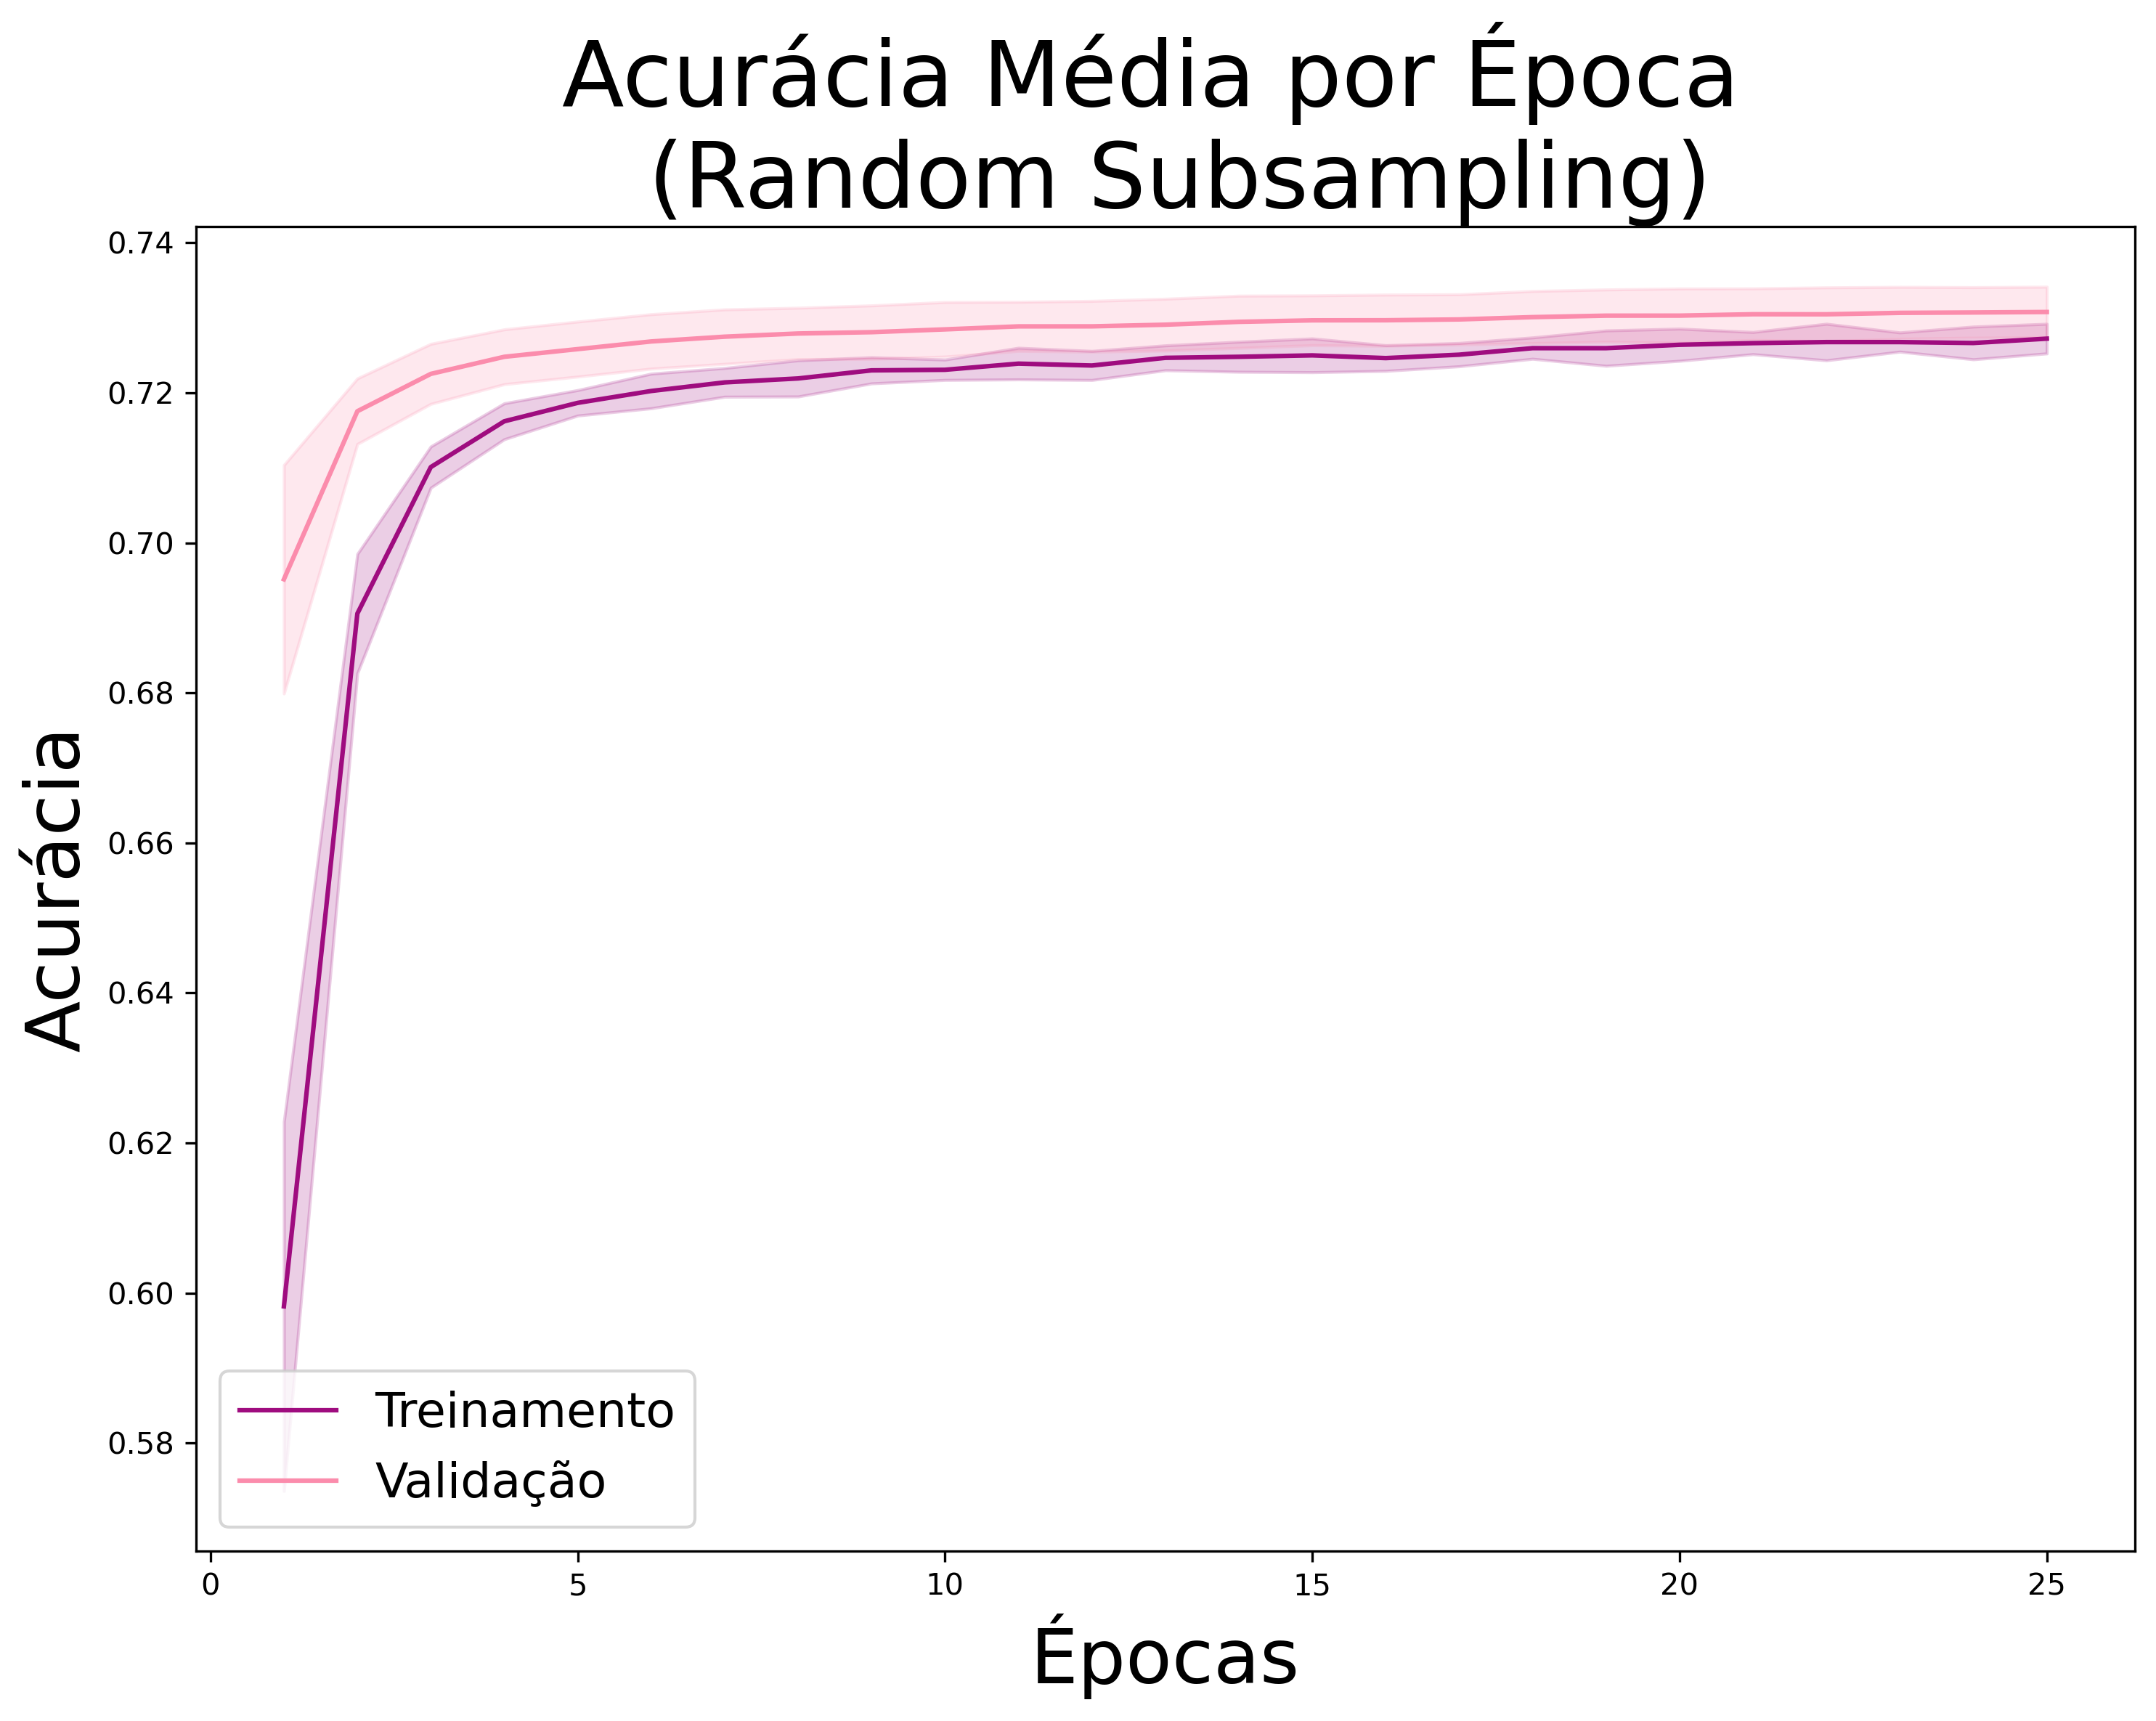

In [22]:
# Visualizando o desempenho durante o treinamento
plt.figure(figsize=(10, 8), dpi=300)

epocas = range(1, min_epocas + 1)

# Curva de treino
plt.plot(epocas, acc_mean, label='Treinamento', color='#9f0c7f')
plt.fill_between(epocas, acc_mean - acc_std, acc_mean + acc_std, alpha=0.2, color='#9f0c7f')

# Curva de validação
plt.plot(epocas, val_acc_mean, label='Validação', color='#fb8cac')
plt.fill_between(epocas, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, alpha=0.2, color='#fb8cac')

plt.xlabel('Épocas', fontsize=25)
plt.ylabel('Acurácia', fontsize=25)
plt.title('Acurácia Média por Época \n (Random Subsampling)', fontsize=30)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('desempenho_rede_neural_random_subsampling.png', dpi=300)
plt.show()

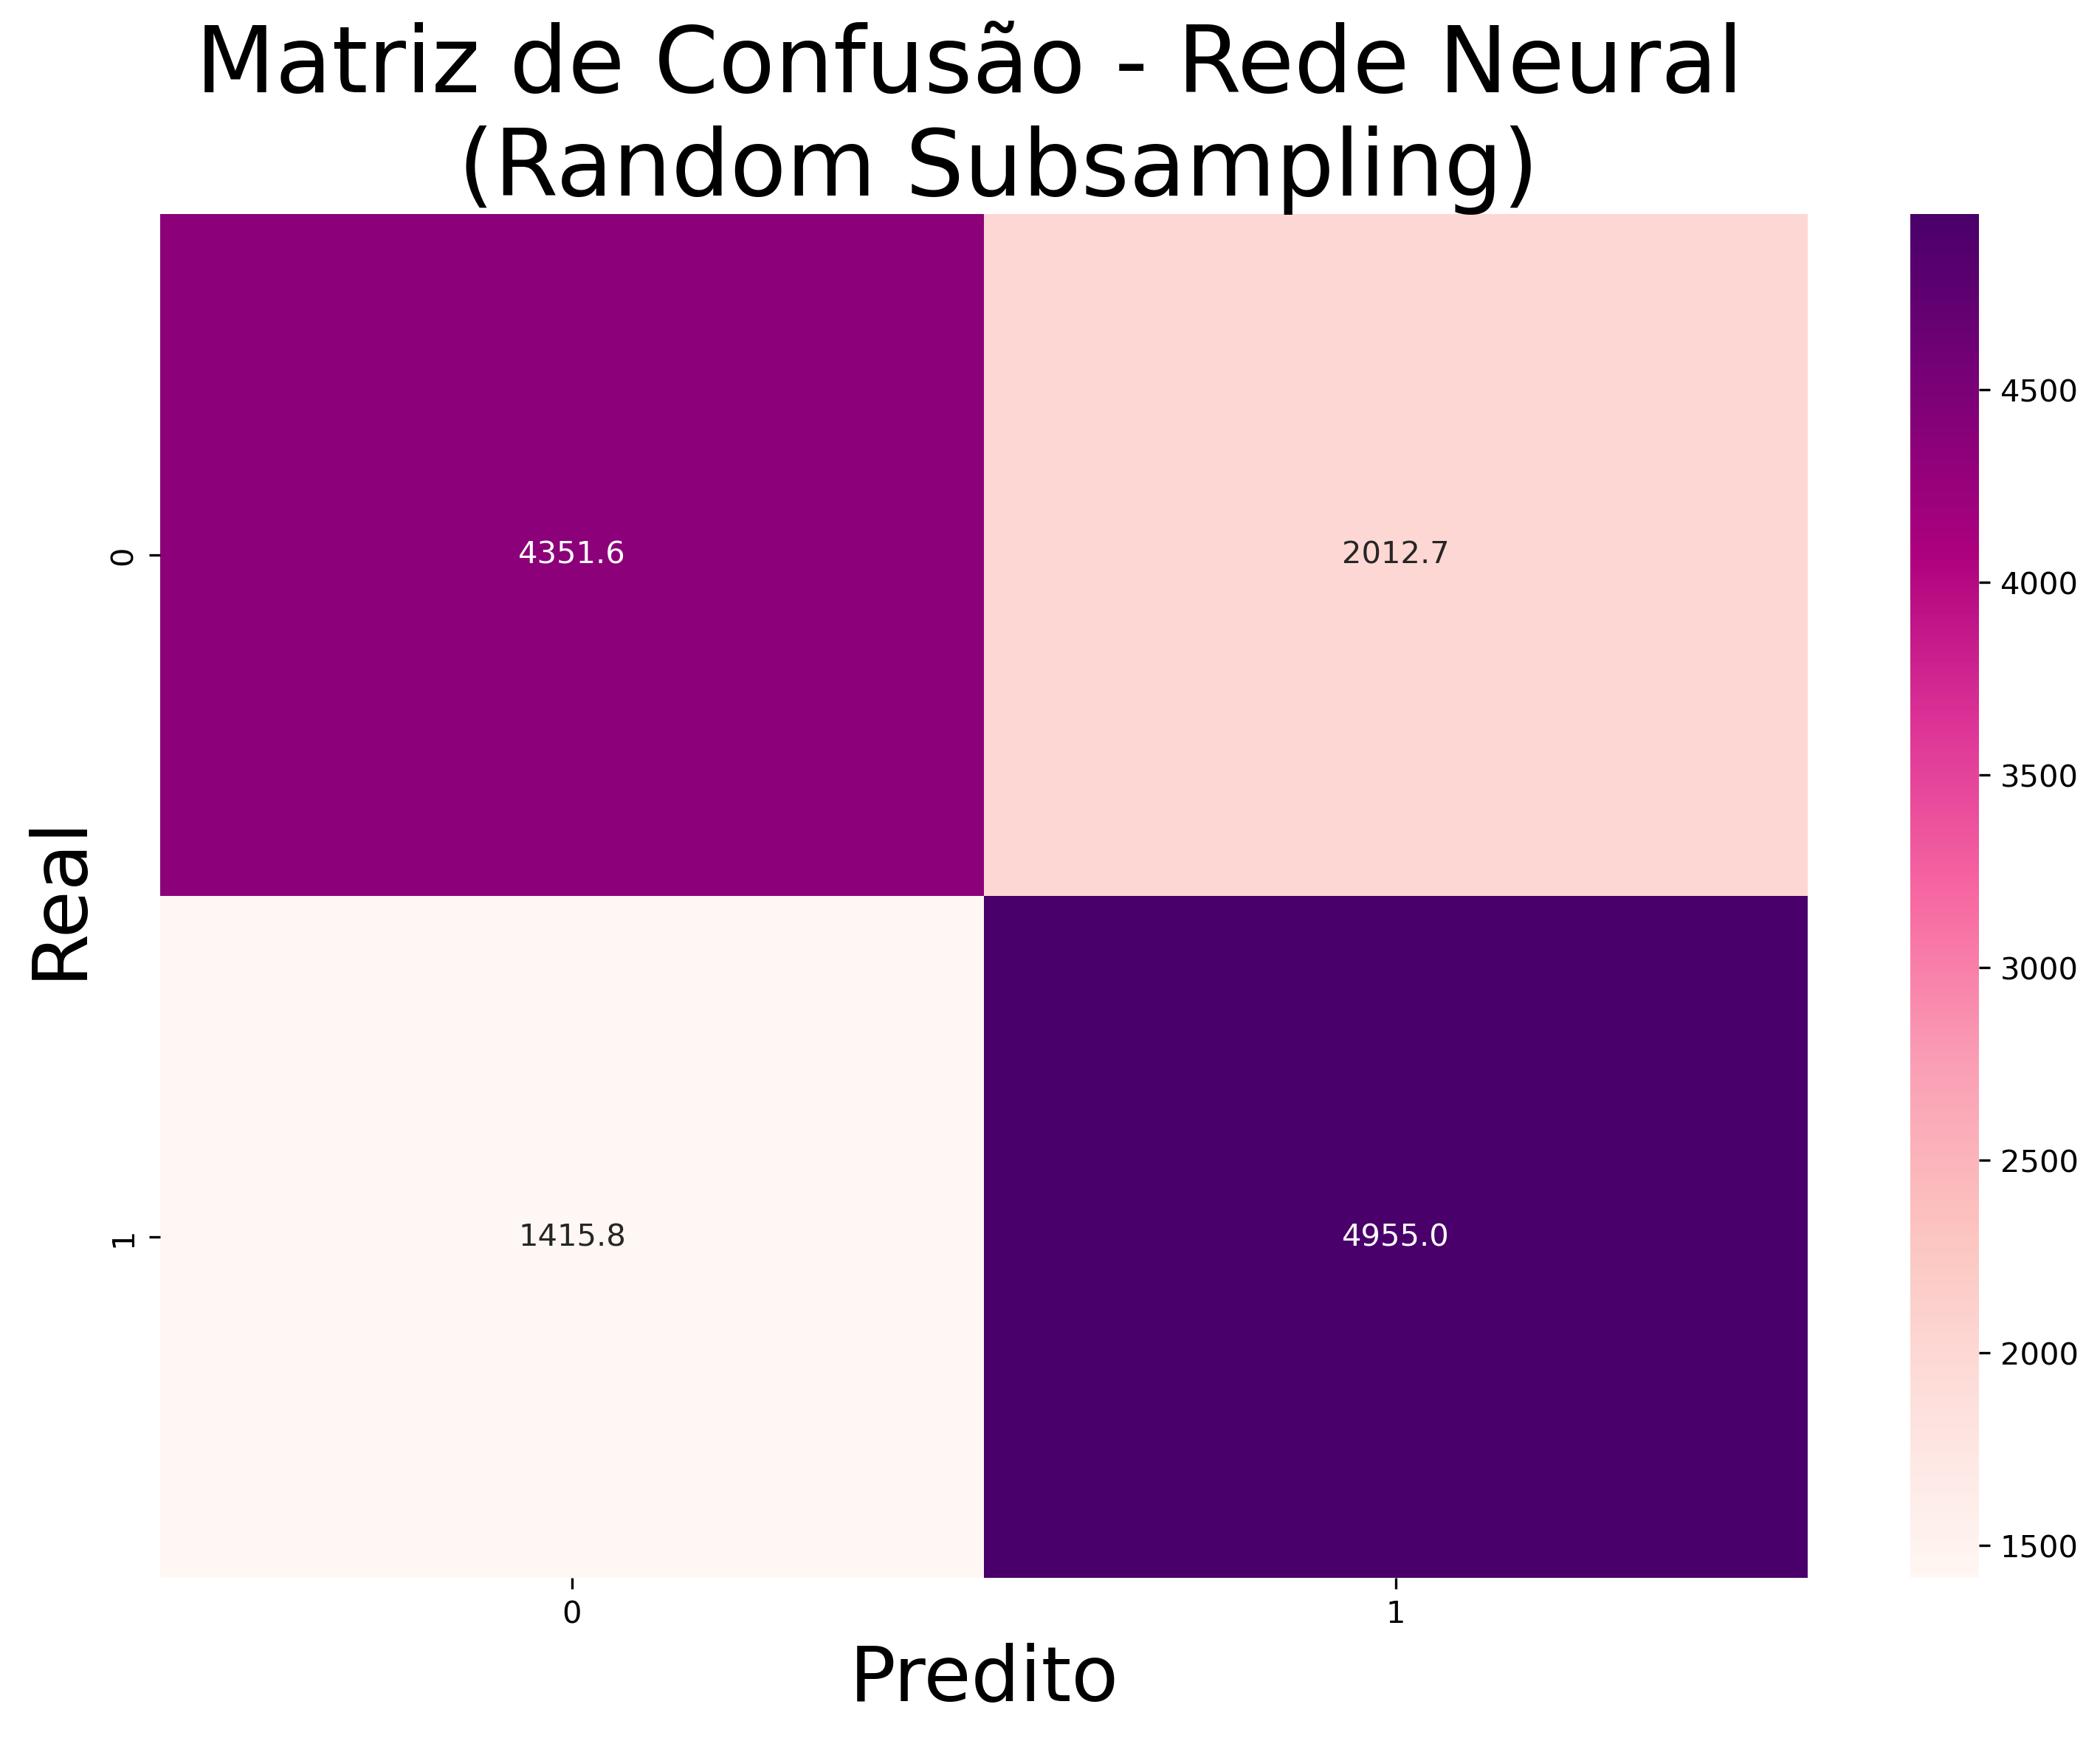

In [23]:
# Matriz de confusão
media_matriz = np.mean(matrizes_confusao, axis=0)

plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(media_matriz, annot=True, fmt=".1f", cmap="RdPu")
plt.xlabel("Predito",fontsize=25)
plt.ylabel("Real",fontsize =25)
plt.title("Matriz de Confusão - Rede Neural \n (Random Subsampling)", fontsize=30)
plt.savefig("rede_neural_matriz_confusao_random_subsampling.png", dpi=300)

### CURVA ROC

C:\Users\apisa\AppData\Local\Temp\ipykernel_6384\2774252678.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", lw=2, color='#a80dbd')


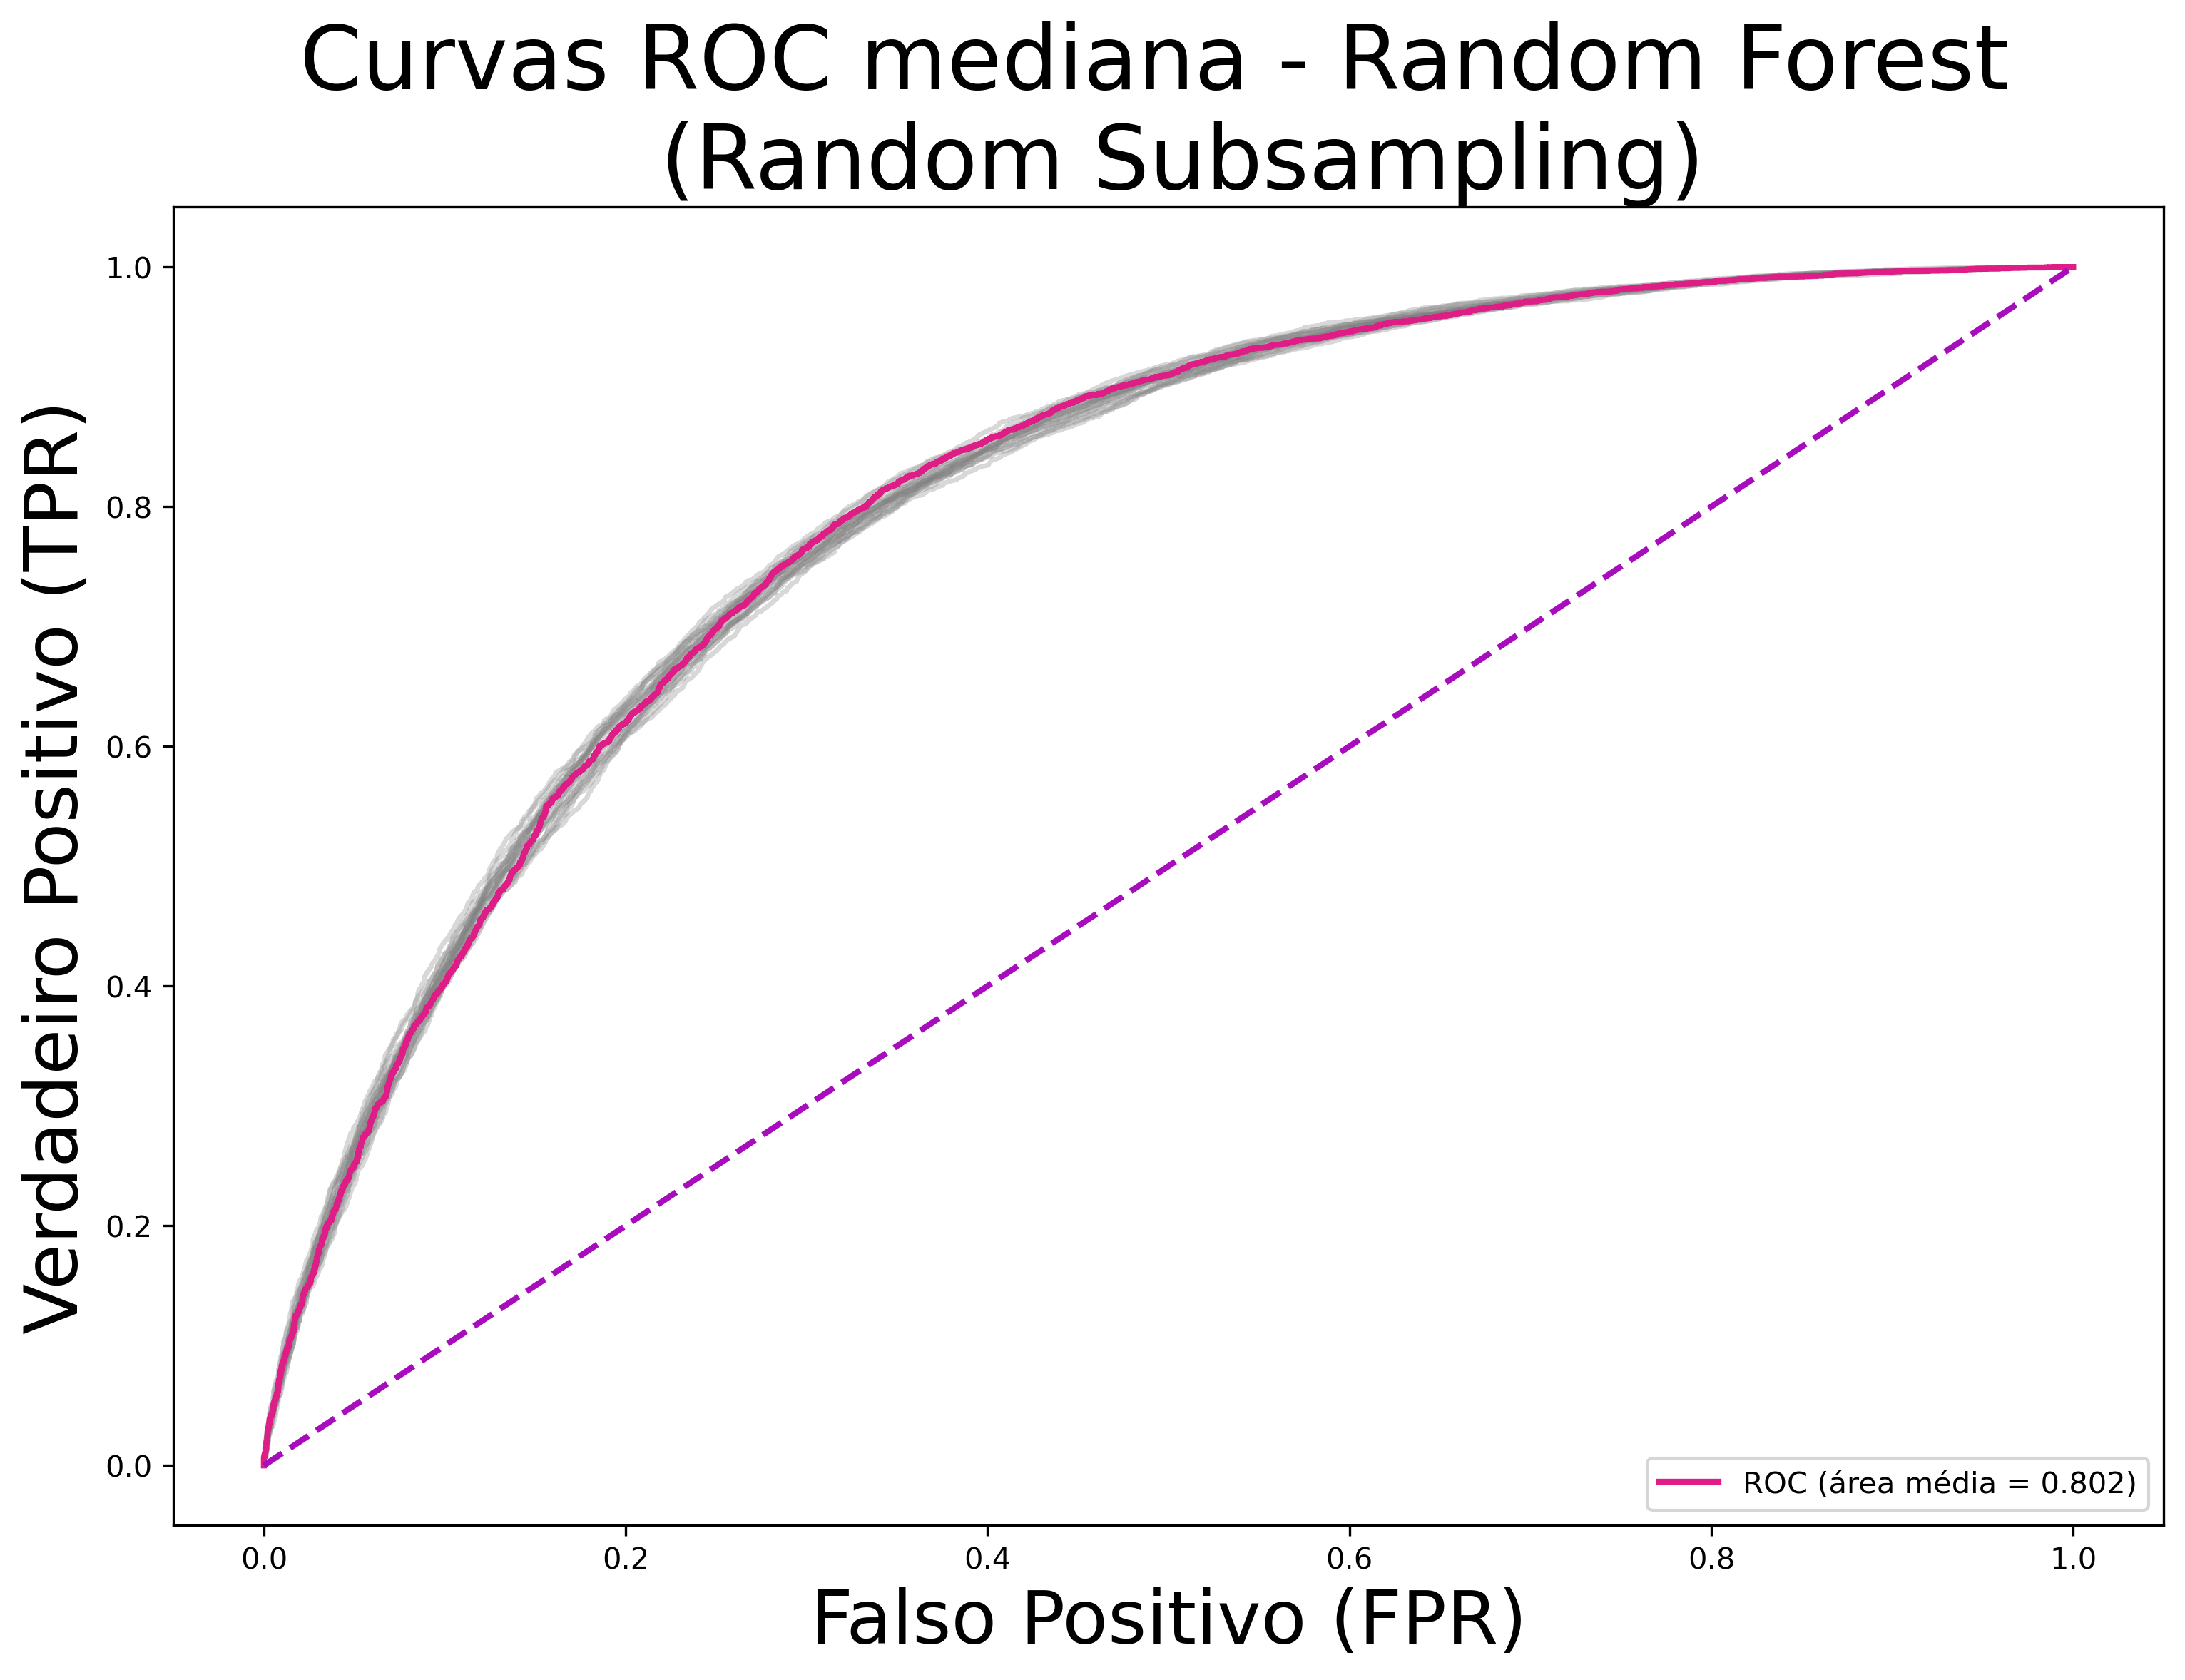

In [24]:
plt.figure(figsize=(12, 8),dpi=300)

# Curvas individuais
for i in range(n_rep):
    plt.plot(fpr_list[i], tpr_list[i], color="gray", alpha=0.3)

# Curva média aproximada
# AUC mediana
idx_mediana = np.argsort(auc_list)[len(auc_list)//2]
plt.plot(fpr_list[idx_mediana], tpr_list[idx_mediana],
         color='#de1d87', lw=2, label=f"ROC (área média = {np.mean(auc_list):.3f})")

# Linha aleatória
plt.plot([0, 1], [0, 1], "k--", lw=2, color='#a80dbd')

plt.xlabel("Falso Positivo (FPR)", fontsize=25)
plt.ylabel("Verdadeiro Positivo (TPR)", fontsize=25)
plt.title("Curvas ROC mediana - Random Forest \n (Random Subsampling)", fontsize=30)
plt.legend(loc="lower right")
plt.savefig("random_forest_curva_roc_random_subsampling.png", dpi=300)